# Testing the guess algorithm - stage A

## Additonal reading material:
1. Quantum optimization of maximum independent set using Rydberg atom arrays - S. Ebadi

In [12]:
import ipynb.fs.defs.guess_algorithm as algo
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

## Making new graphs

The types of graphs we want to test are:
1. chain graphs 
2. bipartite graphs
3. tree graphs
4. cycles

To make it calulatable we Make all graphs with 10 vertexs.

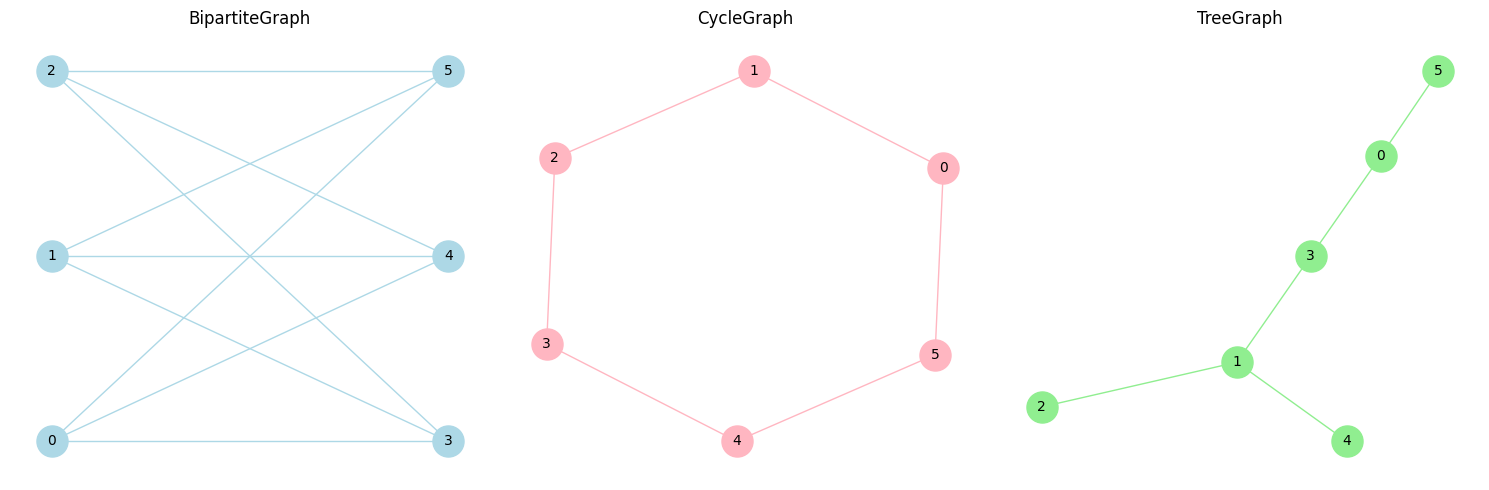

In [51]:
class BipartiteGraph(algo.BaseGraph):
    """Class for generating a random bipartite graph of size N."""
    
    def __init__(self, N):
        super().__init__(N)
        self.partition_size = N // 2

    def create_graph(self):
        """Creates a random bipartite graph with N nodes."""
        # Set sizes for two partitions: products and dates
        product_partition_size = self.partition_size
        date_partition_size = self.N - self.partition_size
        
        # Create a bipartite graph with random edges
        self.graph = nx.bipartite.gnmk_random_graph(product_partition_size, date_partition_size, 10, seed=random.randint(1, 100))

        # Get sets for bipartite layout
        products = {n for n, d in self.graph.nodes(data=True) if d['bipartite'] == 0}
        
        # Create bipartite layout
        self.pos = nx.bipartite_layout(self.graph, products)
    

class CycleGraph(algo.BaseGraph):
    """Class for generating a cycle graph."""
    
    def __init__(self, N):
        super().__init__(N)

    def create_graph(self):
        """Creates a cycle graph by connecting nodes in a circular manner."""
        self.graph = nx.cycle_graph(self.N)

    def plot_graph(self, ax=None):
        """Plots the cycle graph on the given axis."""
        super().plot_graph(ax, color='lightpink')  # Custom color

class TreeGraph(algo.BaseGraph):
    """Class for generating a randomly defined tree graph."""
    
    def __init__(self, N):
        super().__init__(N)

    def create_graph(self):
        """Creates a random tree graph using networkx."""
        self.graph = nx.random_tree(self.N)

    def plot_graph(self, ax=None):
        """Plots the cycle graph on the given axis."""
        super().plot_graph(ax, color='lightgreen')  # Custom color


N = 6

# Creating and plotting graphs
bipartite_graph = BipartiteGraph(N)
bipartite_graph.create_graph()

cycle_graph = CycleGraph(N)
cycle_graph.create_graph()

tree_graph = TreeGraph(N)
tree_graph.create_graph()

# Plot graphs side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each graph on a different axis
bipartite_graph.plot_graph(axes[0])
cycle_graph.plot_graph(axes[1])
tree_graph.plot_graph(axes[2])

plt.tight_layout()
plt.show()

## Building the hamiltonian


First let's look at how each algorithm solves our graphs and make sure they all get proper answers:

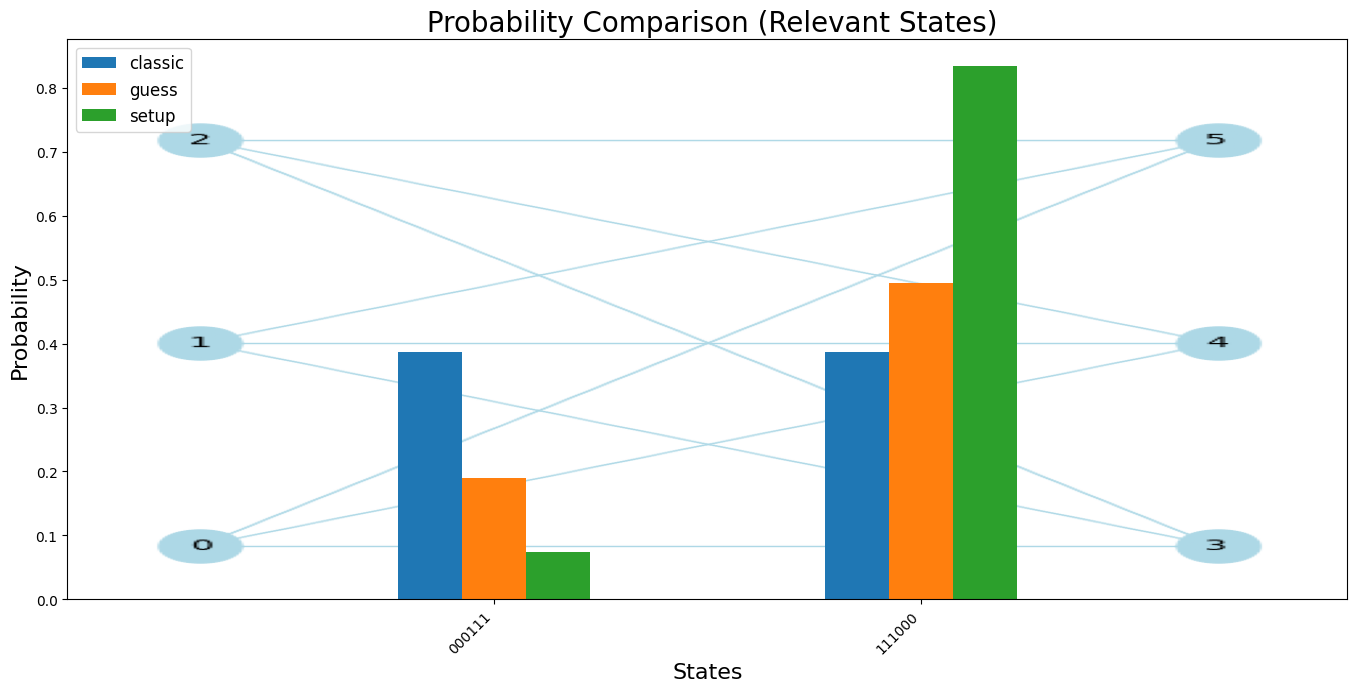

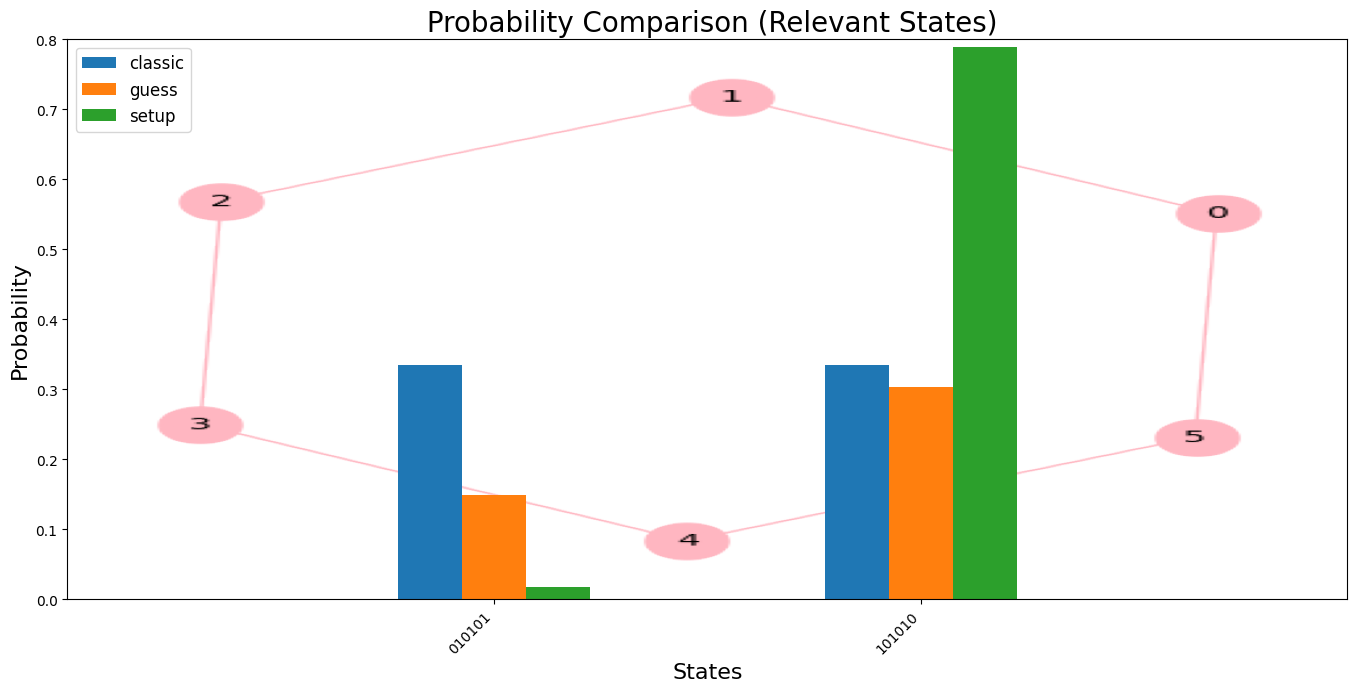

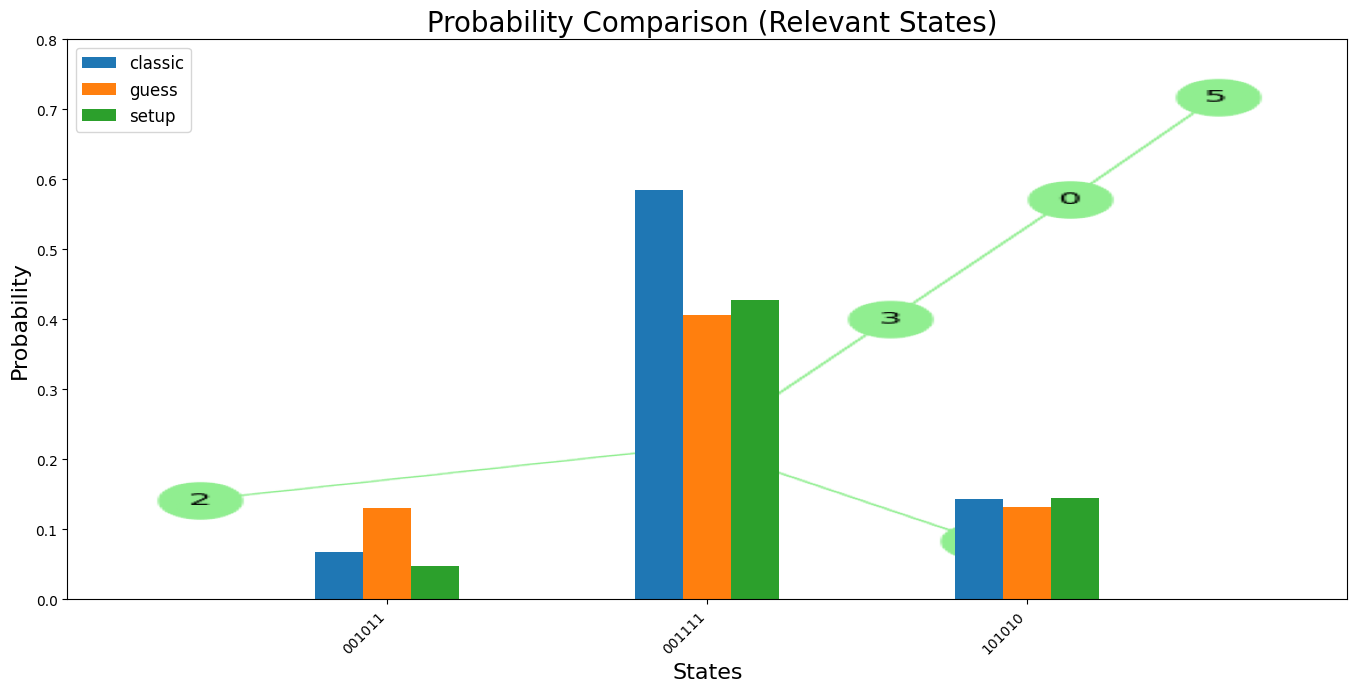

In [62]:
init_params = algo.initialize_system_parameters(delta=10,tau_max=5)
# Initialize dictionaries to store results for each graph type
hamiltonians_dict = {}
results_dict = {}

graph_types = [bipartite_graph, cycle_graph, tree_graph]

for graph in graph_types:
    hamiltonians, psi_states = algo.initialize_states_and_hamiltonians(init_params, graph, guess_func = algo.greedy_guess)
    hamiltonians_out, results_out = algo.solve_hamiltonians(hamiltonians, psi_states, init_params)
    
    # Store the hamiltonians and results in the respective dictionaries
    hamiltonians_dict[graph] = hamiltonians_out
    results_dict[graph] = results_out
    
    # Plot the probabilities for the current graph
    algo.plot_probabilities(results_out, psi_states, N, "", graph)

## Checking complexity

Since the minimal gap is not a good text for more complex graphs (due to divergency), we can check the complexity $R$ in a different way:

$$R = \left \langle \sum_i n_i \right \rangle |MIS|$$

of course $|MIS|$ can be calculated classicly

In [58]:
def maximum_independent_set_info(graph):
    """
    Calculate the size of the maximum independent set and its degeneracy for a given graph.

    Parameters:
    graph (nx.Graph): The input graph for which to calculate the MIS size and degeneracy.

    Returns:
    tuple: A tuple containing the size of the maximum independent set and its degeneracy.
    """

    def backtrack(start, current_set, best_size, degeneracy):
        """Backtrack to find the maximum independent set size and count degeneracy."""
        # Base case: if we've checked all nodes
        if start == len(graph.nodes()):
            current_size = len(current_set)
            if current_size > best_size[0]:
                best_size[0] = current_size
                degeneracy[0] = 1  # Reset degeneracy count for a new best size
            elif current_size == best_size[0]:
                degeneracy[0] += 1  # Increment degeneracy for matching size
            return

        # Try including the current node
        node = list(graph.nodes())[start]
        if all(not graph.has_edge(node, other) for other in current_set):
            current_set.append(node)
            backtrack(start + 1, current_set, best_size, degeneracy)
            current_set.pop()

        # Try excluding the current node
        backtrack(start + 1, current_set, best_size, degeneracy)

    best_size = [0]  # Store the size of the best independent set found
    degeneracy = [0]  # Store the number of independent sets of the best size
    backtrack(0, [], best_size, degeneracy)
    return best_size[0], degeneracy[0]

And $\left \langle \sum_i n_i \right \rangle$ being the mean independent set size of the sampled wave function.

Since we are doing a numerical experiment, we can rewrite it to be equal to the expectation value we calculate:
$$\left \langle \sum_i n_i \right \rangle = \langle \psi(t_f) | \sum_i n_i | \psi(t_f)\rangle = \sum_i \langle \psi(t_f) |  \hat{I}_N \otimes\hat{I}_{N-1} \otimes \dots \otimes |1 \rangle^i \langle 1 |\otimes \dots \otimes I_1 | \psi(t_f)\rangle$$

using all of that we can get our computation error $|1-R|$. We use ablsolute values because in cases there is a possibility of an answer with too many states (which should be highley unlikely because the rydbeg forces repeal reach other), the error can be negaitve. 

In [61]:
_, _, one_list, _ = algo.generate_operators(N)

# Function to compute the expectation value
def compute_expectation_value(psi, operators):
    """Compute the expectation value <ψ|N|ψ> using the projectors."""
    expectation_value = 0
    for op in operators:
        expectation_value += (op * psi).dag() * psi  # <ψ|N|ψ>
    return expectation_value

# Define a list of Hamiltonian keys to loop through
hamiltonian_keys = ["classic", "guess", "setup"]

# Calculate the expectation values for each graph type and each Hamiltonian
for graph_type in graph_types:
    mis_size, mis_degeneracy = maximum_independent_set_info(graph_type.graph)
    for key in hamiltonian_keys:
        # Get the final state from the results dictionary
        final_state = results_dict[graph_type][key].states[-1]  # Get the last state for the specified Hamiltonian

        # Get info on the MIS
        # Calculate the expectation value
        computation_error = abs(1-compute_expectation_value(final_state, one_list)/mis_size)
        # Output the expectation value
        print(f"error for graph type {graph_type}, Hamiltonian {key}: {computation_error}")

error for graph type <__main__.BipartiteGraph object at 0x151a19af0>, Hamiltonian classic: 0.08303153968866728
error for graph type <__main__.BipartiteGraph object at 0x151a19af0>, Hamiltonian guess: 0.0031901387210445664
error for graph type <__main__.BipartiteGraph object at 0x151a19af0>, Hamiltonian setup: 1.538159982417131e-05
error for graph type <__main__.CycleGraph object at 0x1400844a0>, Hamiltonian classic: 0.10429385423196258
error for graph type <__main__.CycleGraph object at 0x1400844a0>, Hamiltonian guess: 0.01701029961712175
error for graph type <__main__.CycleGraph object at 0x1400844a0>, Hamiltonian setup: 1.571356437446436e-05
error for graph type <__main__.TreeGraph object at 0x1519d4170>, Hamiltonian classic: 0.1305285187136246
error for graph type <__main__.TreeGraph object at 0x1519d4170>, Hamiltonian guess: 0.18780926860326785
error for graph type <__main__.TreeGraph object at 0x1519d4170>, Hamiltonian setup: 0.349018770045026


## Building the testing framework

To compare our algorithm to the known ones, we will generate an error vs degeneracy graph for all 3 algorithms. 
The points will be made by randomly generating graphs from all 3 types and collecting them until we the desired_count of each degeneracy. 

Note that we currently only check for tree graphs. needs to be updated.


<>:84: SyntaxWarning: invalid escape sequence '\m'
<>:84: SyntaxWarning: invalid escape sequence '\m'
/var/folders/h_/vy4w9dxn1tj1hk2f15n3qn3m0000gn/T/ipykernel_44418/816664362.py:84: SyntaxWarning: invalid escape sequence '\m'
  plt.title(f"Degeneracy vs Computation Error for Various Graphs and Hamiltonians ($\\tau_{{\max}} = {tau_max}$)", fontsize=16)


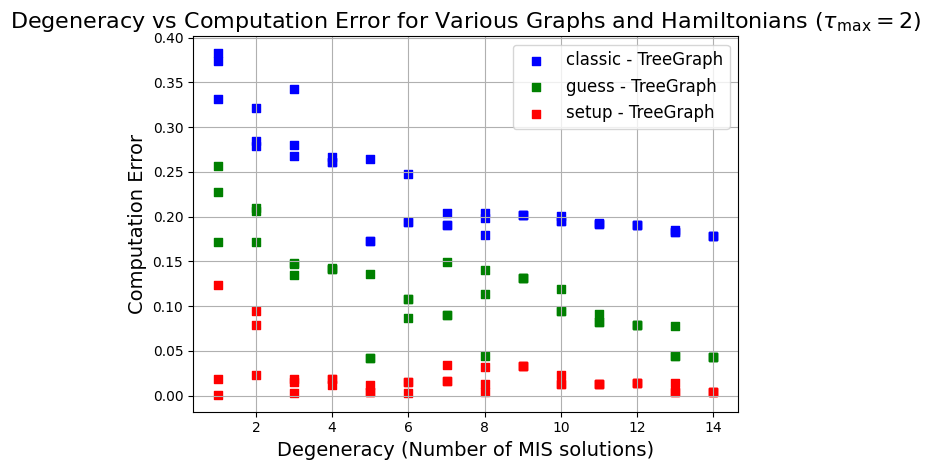

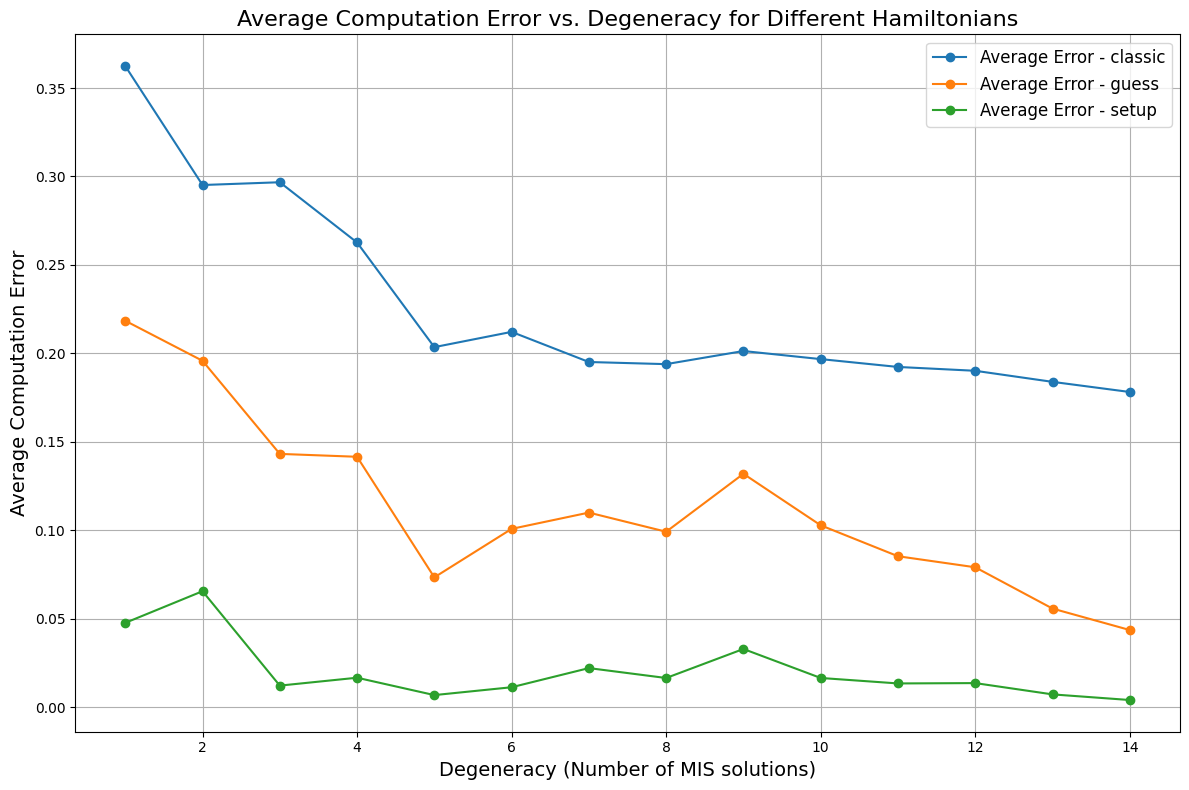

In [18]:
#########################
##  Create the graphs  ##
#########################

def generate_tree_graphs(desired_count=3, max_n=11):
    """Generate a collection of random tree graphs categorized by their MIS degeneracy."""
    graphs_by_degeneracy = {}

    while True:
        N = np.random.randint(6, max_n)
        tree_graph = TreeGraph(N)
        tree_graph.create_graph()

        _, mis_degeneracy = maximum_independent_set_info(tree_graph.graph)

        if mis_degeneracy not in graphs_by_degeneracy:
            graphs_by_degeneracy[mis_degeneracy] = []

        if len(graphs_by_degeneracy[mis_degeneracy]) < desired_count:
            graphs_by_degeneracy[mis_degeneracy].append(tree_graph)

        if all(len(graphs) >= desired_count for graphs in graphs_by_degeneracy.values()):
            break

    return graphs_by_degeneracy

def test_algorithm(graphs_by_degeneracy, init_params):
    """Test the algorithm and compute errors for each graph."""
    plot_data = {
        "classic": {"degeneracies": [], "errors": [], "labels": []},
        "guess": {"degeneracies": [], "errors": [], "labels": []},
        "setup": {"degeneracies": [], "errors": [], "labels": []}
    }

    for _, graphs in graphs_by_degeneracy.items():
        for graph in graphs:
            graph_type_str = type(graph).__name__

            mis_size, mis_degeneracy = maximum_independent_set_info(graph.graph)
            hamiltonians, psi_states = algo.initialize_states_and_hamiltonians(init_params, graph)
            hamiltonians_out, results_out = algo.solve_hamiltonians(hamiltonians, psi_states, init_params)
            _, _, one_list, _ = algo.generate_operators(len(graph.graph.nodes()))

            for key in hamiltonian_keys:
                final_state = results_out[key].states[-1]
                computation_error = 1 - compute_expectation_value(final_state, one_list) / mis_size

                plot_data[key]["degeneracies"].append(mis_degeneracy)
                plot_data[key]["errors"].append(computation_error)
                plot_data[key]["labels"].append(graph_type_str)

    return plot_data

def plot_results(plot_data, tau_max):
    """Plot the computation error against degeneracy for various graphs and Hamiltonians."""
    colors = {"classic": "blue", "guess": "green", "setup": "red"}
    markers = {"CycleGraph": "o", "BipartiteGraph": "D", "TreeGraph": "s"}

    # Scatter plot for individual results
    for key in hamiltonian_keys:
        degeneracies = plot_data[key]["degeneracies"]
        errors = plot_data[key]["errors"]
        labels = plot_data[key]["labels"]

        filtered_data = [
            (deg.real if isinstance(deg, complex) else deg, err, label)
            for deg, err, label in zip(degeneracies, errors, labels)
            if not isinstance(deg, complex)
        ]
        sorted_data = sorted(filtered_data, key=lambda x: x[0])

        degeneracies, errors, labels = zip(*sorted_data)

        for i in range(len(degeneracies)):
            plt.scatter(
                degeneracies[i], errors[i],
                color=colors[key],
                marker=markers[labels[i]],
                label=f"{key} - {labels[i]}" if i == 0 else ""
            )

    plt.xlabel("Degeneracy (Number of MIS solutions)", fontsize=14)
    plt.ylabel("Computation Error", fontsize=14)
    plt.title(f"Degeneracy vs Computation Error for Various Graphs and Hamiltonians ($\\tau_{{\max}} = {tau_max}$)", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_average_errors(plot_data, tau_max):
    """Plot average computation error against degeneracy for various Hamiltonians."""
    average_errors = {key: {} for key in hamiltonian_keys}

    for key in hamiltonian_keys:
        for degeneracy, error in zip(plot_data[key]["degeneracies"], plot_data[key]["errors"]):
            if degeneracy not in average_errors[key]:
                average_errors[key][degeneracy] = []
            average_errors[key][degeneracy].append(error)

    for key in hamiltonian_keys:
        for degeneracy in average_errors[key]:
            average_errors[key][degeneracy] = np.mean(average_errors[key][degeneracy])

    avg_plot_data = {key: ([], []) for key in hamiltonian_keys}

    for key in hamiltonian_keys:
        degeneracies = sorted(average_errors[key].keys())
        avg_errors = [average_errors[key][deg] for deg in degeneracies]
        avg_plot_data[key] = (degeneracies, avg_errors)

    plt.figure(figsize=(12, 8))

    for key in hamiltonian_keys:
        degeneracies, avg_errors = avg_plot_data[key]
        plt.plot(degeneracies, avg_errors, marker='o', label=f'Average Error - {key}', linestyle='-')

    plt.xlabel("Degeneracy (Number of MIS solutions)", fontsize=14)
    plt.ylabel("Average Computation Error", fontsize=14)
    plt.title("Average Computation Error vs. Degeneracy for Different Hamiltonians ($\\tau_{{\max}} = {tau_max}$)", fontsize=16)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
# Set tau_max and initialize parameters
tau_max = 2
init_params = algo.initialize_system_parameters(tau_max=tau_max, vertex_placement=0.9)

# Generate tree graphs
graphs_by_degeneracy = generate_tree_graphs(desired_count=3, max_n=11)

# Test the algorithm
plot_data = test_algorithm(graphs_by_degeneracy, init_params)

# Plot the individual results
plot_results(plot_data, tau_max)

# Plot the average errors
plot_average_errors(plot_data)


## Comparing different max time solutions
Since our complexity report relise on tau_max, we can see how different values of it impact the graph

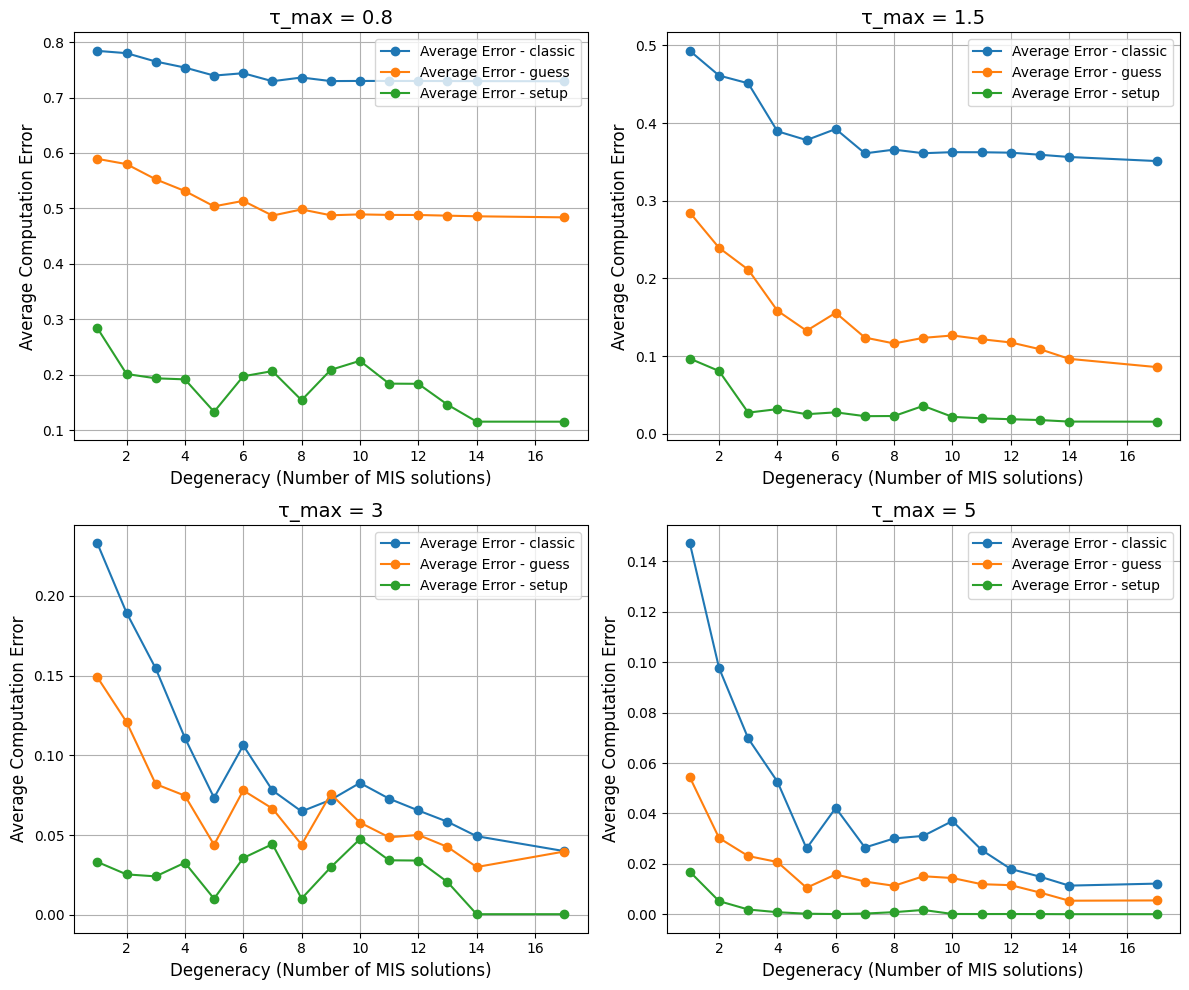

In [21]:
def plot_average_errors_multiple_taus(tau_values, all_plot_data):
    """Plot average computation error against degeneracy for various Hamiltonians for multiple tau values."""
    plt.figure(figsize=(12, 10))

    for idx, tau_max in enumerate(tau_values):
        average_errors = {key: {} for key in hamiltonian_keys}

        # Compute average errors for the current tau_max
        for key in hamiltonian_keys:
            for degeneracy, error in zip(all_plot_data[tau_max][key]["degeneracies"], all_plot_data[tau_max][key]["errors"]):
                if degeneracy not in average_errors[key]:
                    average_errors[key][degeneracy] = []
                average_errors[key][degeneracy].append(error)

        for key in hamiltonian_keys:
            for degeneracy in average_errors[key]:
                average_errors[key][degeneracy] = np.mean(average_errors[key][degeneracy])

        avg_plot_data = {key: ([], []) for key in hamiltonian_keys}

        for key in hamiltonian_keys:
            degeneracies = sorted(average_errors[key].keys())
            avg_errors = [average_errors[key][deg] for deg in degeneracies]
            avg_plot_data[key] = (degeneracies, avg_errors)

        ax = plt.subplot(2, 2, idx + 1)  # Create a 2x2 grid of subplots
        for key in hamiltonian_keys:
            degeneracies, avg_errors = avg_plot_data[key]
            ax.plot(degeneracies, avg_errors, marker='o', label=f'Average Error - {key}', linestyle='-')

        ax.set_xlabel("Degeneracy (Number of MIS solutions)", fontsize=12)
        ax.set_ylabel("Average Computation Error", fontsize=12)
        ax.set_title(f"τ_max = {tau_max}", fontsize=14)
        ax.legend(loc="upper right", fontsize=10)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage for the new plotting function
tau_values = [0.8, 1.5, 3, 5]
all_plot_data = {tau: {} for tau in tau_values}

# Generate tree graphs for each tau value and test the algorithm
for tau in tau_values:
    init_params = algo.initialize_system_parameters(tau_max=tau, vertex_placement=0.9)
    graphs_by_degeneracy = generate_tree_graphs(desired_count=20, max_n=11)
    plot_data = test_algorithm(graphs_by_degeneracy, init_params)
    all_plot_data[tau] = {key: {"degeneracies": plot_data[key]["degeneracies"], "errors": plot_data[key]["errors"]} for key in hamiltonian_keys}

# Plot the average errors for multiple tau values
plot_average_errors_multiple_taus(tau_values, all_plot_data)

# Checking difference based on the distance of the initial guess

Finished collecting graphs for error range 0.0-0.1
Finished collecting graphs for error range 0.1-0.2
Finished collecting graphs for error range 0.2-0.3
Finished collecting graphs for error range 0.3-0.4
Finished collecting graphs for error range 0.4-0.5
Finished collecting graphs for error range 0.5-0.6
Plotting probabilities for the first graph with guess error between 0.6 and 0.7: (0.6+0j)


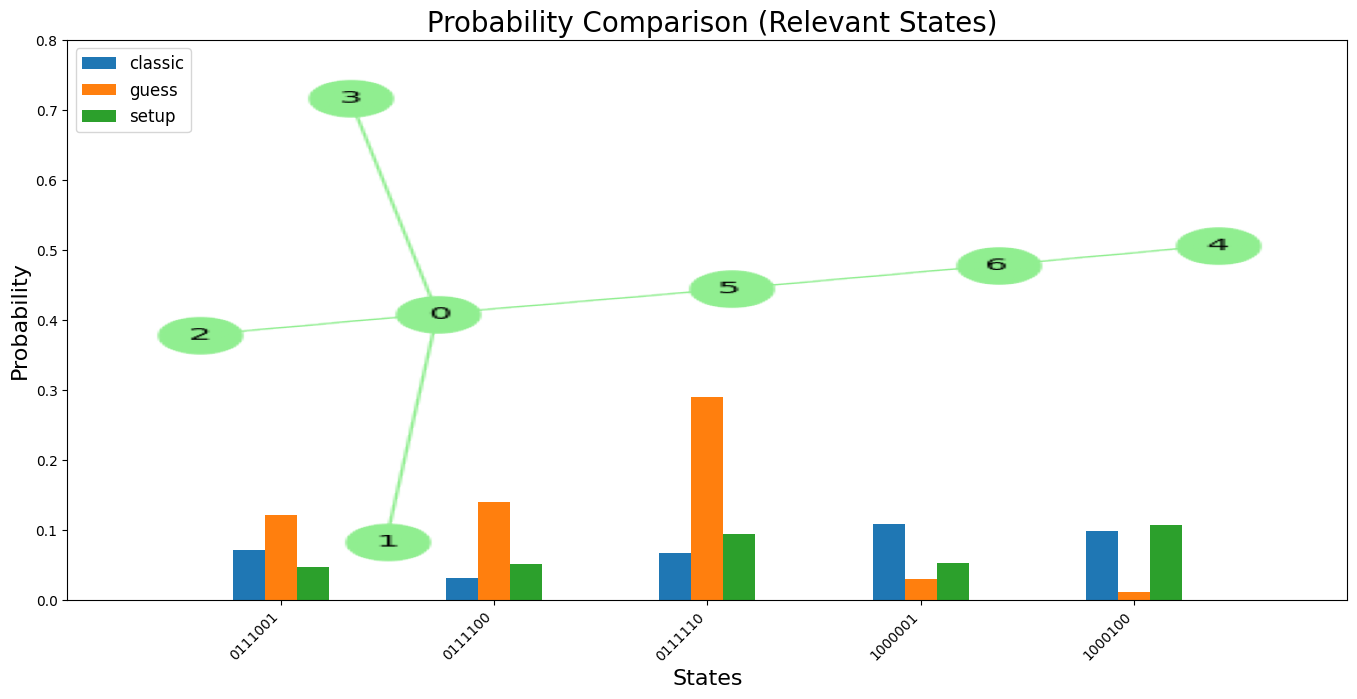

Finished collecting graphs for error range 0.6-0.7


/opt/homebrew/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


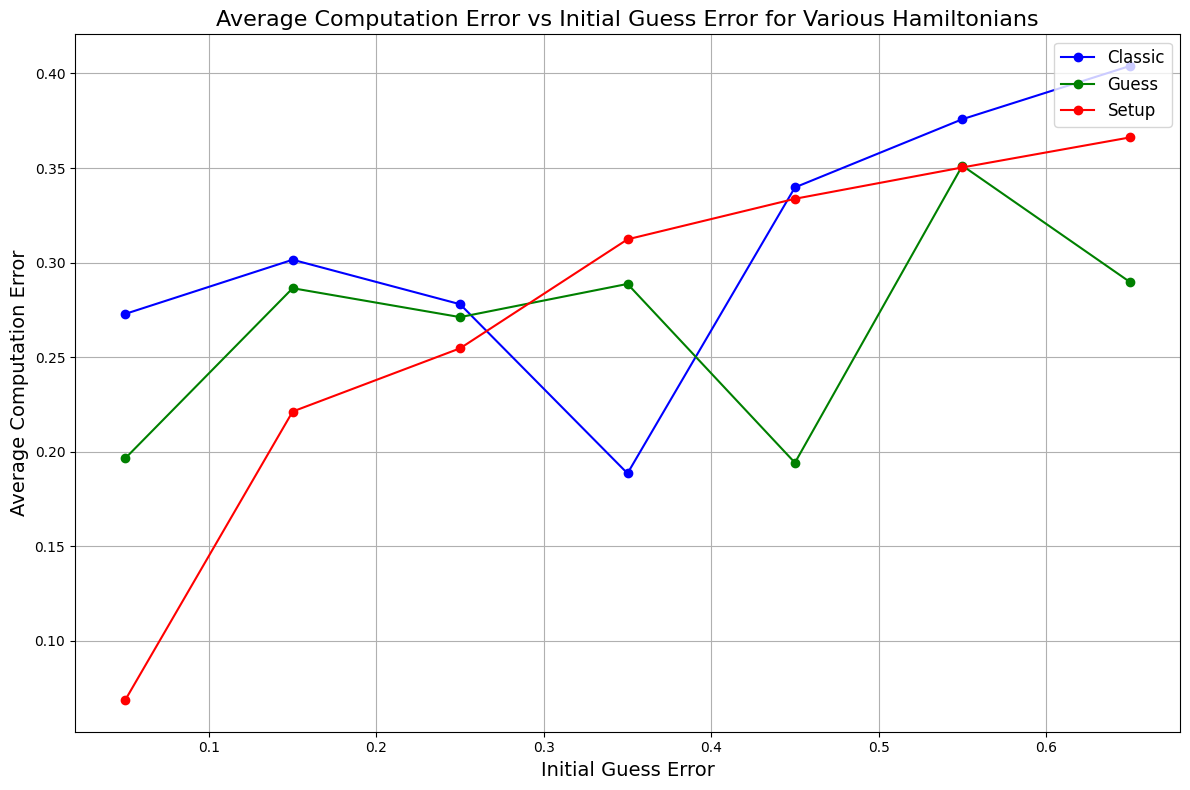

In [76]:
# Initialize color map for Hamiltonians
colors = {"classic": "blue", "guess": "green", "setup": "red"}

init_params = algo.initialize_system_parameters(delta =  5, tau_max=tau_max, vertex_placement=0.8)

# Function to calculate the initial guess error
def calculate_initial_guess_error(graph, guess_func, one_list, mis_size):
    """
    Calculate the initial guess error using the greedy search algorithm.
    
    Parameters:
    - graph: The graph instance.
    - guess_func: Function to compute the guess (e.g., greedy search).
    - one_list: Identity operators (from algo.generate_operators).
    - mis_size: The size of the maximum independent set (MIS).
    
    Returns:
    - error: Computed error for the initial guess.
    """
    # Initialize the states and Hamiltonians for the graph
    init_params = algo.initialize_system_parameters()
    _, psi_states = algo.initialize_states_and_hamiltonians(init_params, graph, guess_func=guess_func)
    
    # Extract the final guess state
    guess_state = psi_states["guess"]
    
    # Compute the expectation value and error for the guess state
    expectation_value = compute_expectation_value(guess_state, one_list)
    error = 1 - expectation_value / mis_size
    
    return error

# Number of graphs per error range
graphs_per_range = 3

# Error range settings (0-0.1, 0.1-0.2, ..., 0.9-1.0)
error_ranges = [(i/10, (i+1)/10) for i in range(7)]

# Prepare data storage for plotting (now includes both guess_errors and comp_errors)
plot_data = {
    "classic": {"guess_errors": [], "comp_errors": []},
    "guess": {"guess_errors": [], "comp_errors": []},
    "setup": {"guess_errors": [], "comp_errors": []}
}

# Flag to check if we've plotted probabilities for error between 0.6 and 0.7
found_probabilities = False

# Loop through error ranges and collect graphs
for error_min, error_max in error_ranges:
    collected_graphs = 0
    
    while collected_graphs < graphs_per_range:
        # Generate a random TreeGraph
        N = np.random.randint(6, 10)  # Random N from 6 to 10
        tree_graph = TreeGraph(N)
        tree_graph.create_graph()

        # Calculate MIS size and degeneracy for the graph
        mis_size, mis_degeneracy = maximum_independent_set_info(tree_graph.graph)
        
        # Calculate initial guess error using the greedy algorithm
        one_list = algo.generate_operators(N)[2]  # Assuming one_list is the 3rd return value
        guess_error = calculate_initial_guess_error(tree_graph, algo.greedy_guess, one_list, mis_size)

        # Check if the error falls within the current range
        if error_min <= abs(guess_error) < error_max:
            collected_graphs += 1  # Increment collected graphs count

            # Compute errors for each Hamiltonian type (classic, guess, setup)
            hamiltonians, psi_states = algo.initialize_states_and_hamiltonians(init_params, tree_graph, guess_func=algo.greedy_guess)
            hamiltonians_out, results_out = algo.solve_hamiltonians(hamiltonians, psi_states, init_params)
            
            # Store computation errors for plotting
            for key in plot_data.keys():  # "classic", "guess", "setup"
                final_state = results_out[key].states[-1]  # Use the final state
                
                # Compute the computation error for this Hamiltonian
                computation_error = 1 - compute_expectation_value(final_state, one_list) / mis_size

                # Store the initial guess error and computation error for plotting
                plot_data[key]["guess_errors"].append(abs(guess_error))  # Store the guess error (x-axis)
                plot_data[key]["comp_errors"].append(computation_error)  # Store the computation error (y-axis)

            # If guess error is between 0.6 and 0.7, plot probabilities for this graph (first one)
            if not found_probabilities and 0.6 <= abs(guess_error) < 0.7:
                print(f"Plotting probabilities for the first graph with guess error between 0.6 and 0.7: {guess_error}")
                algo.plot_probabilities(results_out, psi_states, N, "", tree_graph)
                found_probabilities = True  # Avoid re-plotting for other graphs

    print(f"Finished collecting graphs for error range {error_min}-{error_max}")

# Calculate average computation error per guess error range for each Hamiltonian
avg_plot_data = {
    "classic": {"guess_errors": [], "comp_errors": []},
    "guess": {"guess_errors": [], "comp_errors": []},
    "setup": {"guess_errors": [], "comp_errors": []}
}

for key in plot_data.keys():  # "classic", "guess", "setup"
    # Group data by initial guess error ranges
    for error_min, error_max in error_ranges:
        relevant_errors = [
            comp_err for guess_err, comp_err in zip(plot_data[key]["guess_errors"], plot_data[key]["comp_errors"])
            if error_min <= guess_err < error_max
        ]
        if relevant_errors:  # Ensure there are points in this range
            avg_guess_error = (error_min + error_max) / 2  # Middle of the error range
            avg_comp_error = np.mean(relevant_errors)  # Average computation error

            # Store the averaged data
            avg_plot_data[key]["guess_errors"].append(avg_guess_error)
            avg_plot_data[key]["comp_errors"].append(avg_comp_error)

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot averaged data for each Hamiltonian
for key in avg_plot_data.keys():  # "classic", "guess", "setup"
    plt.plot(
        avg_plot_data[key]["guess_errors"],  # X-axis: average guess error
        avg_plot_data[key]["comp_errors"],   # Y-axis: average computation error
        color=colors[key],
        marker='o',  # Use marker for visibility
        label=f"{key.capitalize()}"  # Capitalize for cleaner labels (Classic, Guess, Setup)
    )

# Labeling and legend
plt.xlabel("Initial Guess Error", fontsize=14)
plt.ylabel("Average Computation Error", fontsize=14)
plt.title("Average Computation Error vs Initial Guess Error for Various Hamiltonians", fontsize=16)

# Show a simplified legend (only one entry per Hamiltonian)
plt.legend(loc="upper right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()